# Quick Start

In this notebook:
* Setup ApertureDB database server 
* Setup a Google Colab notebook with aperturedb client
* Then configure it
* Load a dataset ApertureDB server
* Query!

## 1. Set up the Database

ApertureDB is set up as a database (server) and can be accessed from clients anywhere as long as the server is accessible on the network to the client.

Sign up for an Aperture [cloud account here](https://aperturedata.io/cloud) (30 days free trial) or see [other methods here](http://docs.aperturedata.io/category/setup-server)

## 2. Set up the Client

### a) Launch Colab or Jupyter Server

* Run any of our notebooks on Google Colab or your own Jupyter server as indicated from Step 2.b) onwards.
* You can use our [pre-configured Jupyter server](https://docs.aperturedata.io/Setup/client/notebooks?notebooks=notebook) 
* This jupyter lab launches on port 8888 which will already have the SDK installed.
  
```bash
docker run --interactive --tty aperturedata/aperturedb-notebook
```

### b) Install ApertureDB SDK

In [ ]:
%pip install --quiet --upgrade aperturedb

### c) Define server configuration

**On ApertureDB-Cloud**

When you click on Connect for your instance, you can copy the JSON configuration string for your server. It looks like:

<!-- ![cloud](images/connect_on_cloud.png) -->
<img src="images/connect_on_cloud.png" alt="drawing" width="600"/> <img src="images/connect_json.png" alt="drawing" width="600"/>

```javascript title="template only. Use actual values"
{
  "host": "<hostname>",
  "port": 55555,
  "username": "admin",
  "password": "[User enters passwd here]",
  "name": "demo",
  "use_ssl": true,
  "use_rest": false,
  "use_keepalive": true,
  "retry_interval_seconds": 1,
  "retry_max_attempts": 3
}
```

> **Information**
>
> For any other method, the parameters for `host` will depend on where the database is hosted.
>
> Default username:password values are `admin`:`admin`.
>
> Default `port` that ApertureDB listens on is `55555` (on linux) or `55557` (on MacOS).

### d) For Colab - Add Server Configuration to Secrets

The easiest way to configure one or more Colab notebooks to point to the same ApertureDB server is to put the JSON config into a Colab secret.

This secret will persist over runtime restarts and can be used by all of your notebooks, but it will not be exposed if you share your notebook with anyone.

![Screenshot of setting a Colab Secret](images/colab-secret.png)

1. Click on the key icon at the left of Google Colab to open the Secrets interface.
2. Click on "Add new secret"
3. Ensure that "Notebook access" is enabled
4. For the name, enter `APERTUREDB_JSON`
5. Paste the JSON object into the "Value" box.

### e) For Jupyter lab - Run adb config create

If there is no active configuration, a new one needs to be created as a one time setup. It's interactive and will ask you for the parameters needed to create a connection.

It will used for all subsequent ApertureDB connections and the command line utility `adb` has an easy command switch between instances.

In [ ]:
! adb config create my_adb_config

## 3. Connect ApertureDB Client and Server

As a demonstration that you have connected to the server successfully, let's see a summary of the database schema.  
The first time you do this, you may need to grant permission for this notebook to access your secrets.

In [ ]:
from aperturedb.Utils import Utils
from aperturedb.CommonLibrary import create_connector

# Create the connector for ApertureDB
connector = create_connector()

# Use the connector to create a Utils object and print the summary
utils = Utils(connector)
utils.summary()

## 4. Ingest Our Example Cookbook Data

>**Cookbook Dataset** is a dataset comprising of Dishes(their photos, descriptions), mapped to the constituent main ingredients.
>
>It is a small Dataset built to show the capabilities of ApertureDB.

* [Cookbook Dataset](https://docs.google.com/spreadsheets/d/1G1HPG3Dxx5W39OD6b74wMHvWupD7N-DLUbV7tD5owx8/edit?gid=0#gid=0)
* [Git Repository](https://github.com/aperture-data/Cookbook)
* [More details on how to ingest](https://docs.aperturedata.io/HowToGuides/Ingestion/Ingestion/Examples/Loading_CSVParsers)

In [ ]:
! wget https://github.com/aperture-data/Cookbook/blob/quick_start/scripts/load_cookbook_data.sh
! bash ingest_cookbook_data.sh

## 5. Run Queries!

### a) Find images of dishes from Scottish Cuisine

In [ ]:
from aperturedb.CommonLibrary import create_connector, execute_query
from aperturedb.NotebookHelpers import display

query = [
  {
    "FindImage": {
      "blobs": True,
      "constraints": {
        "cuisine": [
          "==",
          "Scottish"
        ]
      },
      "results": {
        "limit": 5,
        "all_properties": True
      }
    }
  }
]
client = create_connector()
result, response, blobs = execute_query(client, query, [])

# Print the response
print(response)

# Check if the query was successful
if result == 0:
  display(blobs)


### b) Find images and information of dishes with butter and chicken in them

In [ ]:
from aperturedb.CommonLibrary import create_connector, execute_query
from aperturedb.NotebookHelpers import display

query = [
  {
    "FindEntity": {
      "with_class": "Ingredient",
      "constraints": {
        "name": [
          "==",
          "butter"
        ]
      },
      "_ref": 1,
    }
  },
  {
    "FindEntity": {
      "with_class": "Ingredient",
      "constraints": {
        "name": [
          "==",
          "chicken"
        ]
      },
      "_ref": 2
    }
  },
  {
    "FindImage": {
      "blobs": True,
      "is_connected_to": {
        "all": [
          {
            "ref": 1,
          },
          {
            "ref": 2,
          }
        ]
      },
      "results": {
        "limit": 5,
        "all_properties": True
      }
    }
  }
]
client = create_connector()
result, response, blobs = execute_query(client, query, [])

# Print the response
print(response)

# Check if the query was successful
if result == 0:
  display(blobs)


### c) Find similar looking dishes to a bread

[{'FindDescriptor': {'entities': [{'_distance': 150.95266723632812}, {'_distance': 151.56906127929688}, {'_distance': 153.44091796875}, {'_distance': 157.14517211914062}, {'_distance': 157.2300262451172}], 'returned': 5, 'status': 0}}, {'FindImage': {'blobs_start': 0, 'entities': [{'Recipe URL': 'https://www.loveandlemons.com/baked-potato/', '_blob_index': 0, '_uniqueid': '7.5.860', 'adb_data_source': 'IngestType.IMAGE.dishes.adb.csv', 'adb_image_height': 4032, 'adb_image_id': '6', 'adb_image_sha256': '4032a6599dae296071d2c800fe5c51433bec9eea1fecf7413248e1254539d40d', 'adb_image_size': 1390983, 'adb_image_width': 3024, 'caption': 'Baked potato with Scottish Cheddar, Branston Pickles and a side salad of iceberg letture and cherry tomatoes ', 'contributor': 'gavin', 'cuisine': 'Scottish', 'id': 6, 'location': 'UK', 'name': 'baked potato', 'type': 'main dish'}, {'Recipe URL': 'https://cooktoria.com/scrambled-egg-toast/', '_blob_index': 1, '_uniqueid': '7.11.980', 'adb_data_source': 'Inges

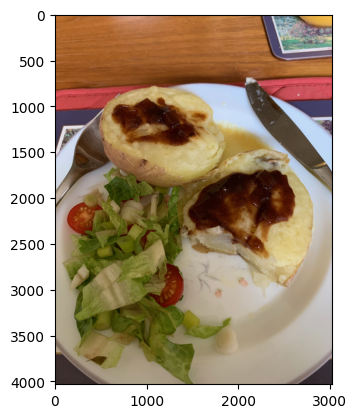

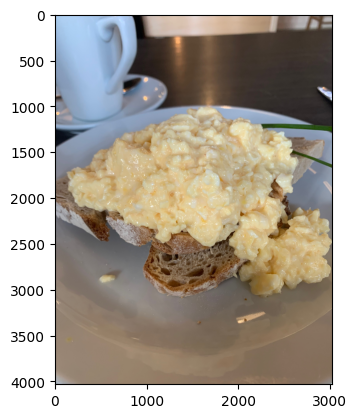

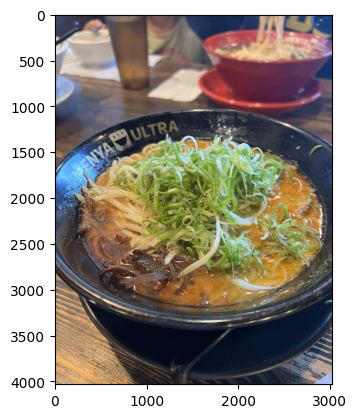

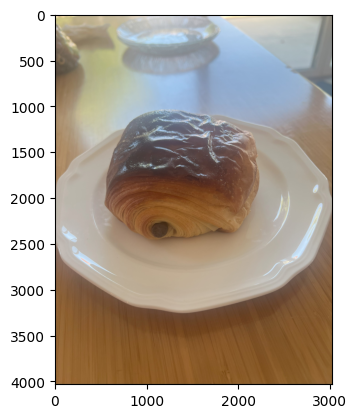

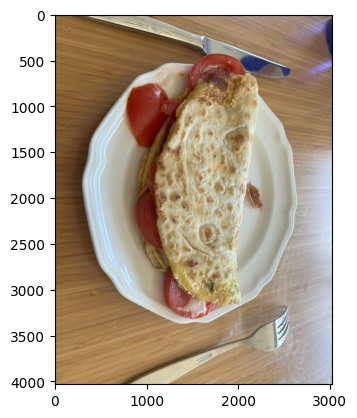

In [15]:
from aperturedb.CommonLibrary import create_connector, execute_query
from aperturedb.NotebookHelpers import display
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device)

search_tokens = clip.tokenize([f"a photo of bread"]).to(device)
search_embeddings = model.encode_text(search_tokens)

query = [{
    "FindDescriptor": {
        "set": "ViT-B/16",
        "k_neighbors": 5,
        "distances": True,
        "blobs": False,
        "_ref": 1
    }
}, {
    "FindImage": {
        "_ref": 2,
        "blobs": True,
        "is_connected_to": {
            "ref": 1
        },
        "results": {
            "all_properties": True
        }
    }
}]

if device == "cuda":
    search_embeddings = search_embeddings.float()
    blobs = search_embeddings[0].cpu().detach().numpy().tobytes()
else:
    blobs = search_embeddings[0].detach().numpy().tobytes()

client = create_connector()
result, response, blobs = execute_query(client, query, [blobs])

# Print the response
print(response)

# Check if the query was successful
if result == 0:
  display(blobs)
